#  What's Cooking?

**Course:** Foundations of Data Science <br>
**Project:** An exploratory analysis of New York city’s restaurant inspection data<br>
**Members:**
* Shaival Dalal: sd3462
* Vaishali Pari: vp1096

**Data Sources:**
* NYC Restaurant Inspection data from: https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j
* Social Data from Yelp Fusion API: https://yelp.com


**Problem Statement:**<br>
Predict Yelp rating of a restaurant based on Department of Health and Mental Health's inspection score.<br/><br/>
**Prediction Models Used:** <br>
* Decision Tree
* Random Forest
* K-Nearest Neighbours
* Logistic Regression
* Support Vector Machine<br><br>

**Exploratory Analysis**<br>
We can answer some questions by analysing the data collected from the above sources. The questions are:
* Most hygienic restaurant for every cuisine (bakery, Asian, Mexican etc.)
* Most common health code violation of restaurants 

**Step 1: Data Loading**<br>

In [1]:
##
## Import
##
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
##
## Data reading
##
#Read NYC Open Data for restaurant inspections
nyc=pd.read_csv("NYCData.csv",header=0,na_values=['','Missing'],low_memory=False)

# We convert some columns to date time for better representation of data
nyc['inspection_date']=pd.to_datetime(nyc['inspection_date'])
nyc['grade_date']=pd.to_datetime(nyc['grade_date'])
nyc['record_date']=pd.to_datetime(nyc['record_date'])

#Display columns containing null values
display(pd.isnull(nyc).sum())
print('The total number of records are: {0:,}'.format(len(nyc)))

camis                         0
dba                         334
boro                         17
building                    130
street                        5
zipcode                       5
phone                         3
cuisine_description           0
inspection_date               0
action                     1117
violation_code             6316
violation_description      6890
critical_flag                 0
score                     22642
grade                    201937
grade_date               204287
record_date                   0
inspection_type            1117
dtype: int64

The total number of records are: 397,584


**Step 2. Data Cleaning** - Handling missing values<br>
We check the data for Null values and remove those entries for which a Null would be unacceptable. We perform basic cleaning in this section and prepare datasets separately for each question to better suit the requirements.

In [3]:
## 
## Data Cleaning
##
# We clean the data by deleting rows containing Null values in the restaurant name (dba) as it 
# is unacceptable for this project
clean=nyc.drop(nyc[nyc['dba'].isnull()].index)

# We remove rows containing Null values in inspection type since every record has to be associated
# with an inspection.
clean=nyc.drop(nyc[nyc['inspection_type'].isnull()].index)
display(pd.isnull(clean).sum())

camis                         0
dba                           0
boro                         11
building                    125
street                        0
zipcode                       0
phone                         0
cuisine_description           0
inspection_date               0
action                        0
violation_code             5199
violation_description      5773
critical_flag                 0
score                     21525
grade                    200821
grade_date               203170
record_date                   0
inspection_type               0
dtype: int64

In [4]:
# We check restaurants for which the borough is missing
display(clean.loc[clean.boro.isnull(),('dba','boro','building','street','zipcode')])

# Since there is only one restaurant with missing details, we can manually assign values.
clean.loc[clean.dba=='WILLIAMBURG THAI CUISINE','boro']='MANHATTAN'
display(pd.isnull(clean).sum())

,dba,boro,building,street,zipcode
353144,WILLIAMBURG THAI CUISINE,NaN,212,BEDFORD AVE,11249.0
353145,WILLIAMBURG THAI CUISINE,NaN,212,BEDFORD AVE,11249.0
353146,WILLIAMBURG THAI CUISINE,NaN,212,BEDFORD AVE,11249.0
353147,WILLIAMBURG THAI CUISINE,NaN,212,BEDFORD AVE,11249.0
353148,WILLIAMBURG THAI CUISINE,NaN,212,BEDFORD AVE,11249.0
353149,WILLIAMBURG THAI CUISINE,NaN,212,BEDFORD AVE,11249.0
353150,WILLIAMBURG THAI CUISINE,NaN,212,BEDFORD AVE,11249.0
353151,WILLIAMBURG THAI CUISINE,NaN,212,BEDFORD AVE,11249.0
353152,WILLIAMBURG THAI CUISINE,NaN,212,BEDFORD AVE,11249.0
353153,WILLIAMBURG THAI CUISINE,NaN,212,BEDFORD AVE,11249.0


camis                         0
dba                           0
boro                          0
building                    125
street                        0
zipcode                       0
phone                         0
cuisine_description           0
inspection_date               0
action                        0
violation_code             5199
violation_description      5773
critical_flag                 0
score                     21525
grade                    200821
grade_date               203170
record_date                   0
inspection_type               0
dtype: int64

In [5]:
# We look at missing violation descriptions and compare them with listed violation codes.
violations=clean.violation_description.isnull().groupby(clean.violation_code).sum()
display(pd.DataFrame({'Codes':violations.index,'Nulls':violations.values.astype(int),'Total':clean.groupby(['violation_code']).size().values}).sort_values(['Nulls'],ascending=False).head(10))

# For certain codes, all entries lack a description, however for 15E, most are Null while 2 values seem to 
# have a description
print('15E is used to indicate: {0}'.format((set(clean.loc[(clean.violation_code=='15E') & (~clean.violation_description.isnull()),'violation_description']))))

# We assign this description to all rows where violation code is 15E
clean.loc[clean.violation_code=='15E','violation_description']='Out-of package sale of tobacco products observed.'

,Codes,Nulls,Total
97,22F,336,336
68,15F,175,175
98,22G,33,33
67,15E,20,22
66,15A,7,7
87,19A,2,2
82,17A,1,1
62,10G,0,56
71,15J,0,124
70,15I,0,628


15E is used to indicate: {'Out-of package sale of tobacco products observed.'}


In [6]:
# By referring to the 
# https://data.cityofnewyork.us/w/3yud-pjyw/25te-f2tw?cur=2jmjyvTAXO1&from=9MsO3Xm4fPA
# we come to know that 22F, 15F, 22G, 15A, 19A and 17A are codes with no description. We can eliminate such
# records as they don't depict a clear picture
clean=clean[~clean.violation_code.isin(['22F','15F','22G','15A','19A','17A'])]
display(pd.isnull(clean).sum())

camis                         0
dba                           0
boro                          0
building                    125
street                        0
zipcode                       0
phone                         0
cuisine_description           0
inspection_date               0
action                        0
violation_code             5199
violation_description      5199
critical_flag                 0
score                     21343
grade                    200483
grade_date               202826
record_date                   0
inspection_type               0
dtype: int64

In [7]:
# We now have the same number of violation codes missing as violation descriptions, a stituation that 
# occurs only when a restaurant has no recorded violations during an inspection. We verify it to be sure.
display(clean.loc[(clean.violation_code.isnull()) & ~(clean.violation_description.isnull())])

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type


In the above output, we see that all missing violation codes are accompanied missing violation descriptions i.e. no record exists where only either one of the two is missing. We check the actions carried out in order to assign a probable cause for these missing values.

In [8]:
# Now we look at the missing violation codes and compare it with the action taken by inspectors
# to understand if there exists any pattern in the missing values
display(clean.violation_code.isnull().groupby(clean.action).sum().astype(int).to_frame("Missing Codes"))

,Missing Codes
action,
Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.,1
Establishment re-closed by DOHMH,0
Establishment re-opened by DOHMH,200
No violations were recorded at the time of this inspection.,4951
Violations were cited in the following area(s).,47


Majority of inspections where a violation description is missing, the restaurants have had no signs of violations. However, there are some records where violations were cited by a mention of violation code has not been made.

In [9]:
# There are records indicating violations but they do not mention any violation codes. We explore
# these records to understand more about them.
display(clean.loc[(clean.violation_code.isnull()) & (clean.action.str.contains('Violations were cited'))])

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type
52621,40860723,PURITY DINER,BROOKLYN,289,7 AVENUE,11215.0,7188400881,American,2014-08-06,Violations were cited in the following area(s).,NaN,NaN,Not Applicable,0.0,A,2014-08-06,2017-10-19 06:00:49,Cycle Inspection / Initial Inspection
62982,40959046,BAR 13,MANHATTAN,35,EAST 13 STREET,10003.0,2129796677,American,2014-07-18,Violations were cited in the following area(s).,NaN,NaN,Not Applicable,NaN,NaN,NaT,2017-10-19 06:00:49,Cycle Inspection / Reopening Inspection
64641,40976390,MONA'S BAKERY & CAFE,BROOKLYN,281,KINGS HIGHWAY,11223.0,3473234249,Bakery,2017-01-09,Violations were cited in the following area(s).,NaN,NaN,Not Applicable,0.0,A,2017-01-09,2017-10-19 06:00:49,Cycle Inspection / Re-inspection
64771,40977606,MIKE'S TAVERN,QUEENS,8814,LIBERTY AVENUE,11417.0,7188459322,American,2016-12-13,Violations were cited in the following area(s).,NaN,NaN,Not Applicable,0.0,A,2016-12-13,2017-10-19 06:00:49,Cycle Inspection / Re-inspection
70089,41018004,ANGELICA PIZZERIA,BROOKLYN,30,NEVINS STREET,11217.0,7188522728,Pizza/Italian,2015-02-02,Violations were cited in the following area(s).,NaN,NaN,Not Applicable,0.0,A,2015-02-02,2017-10-19 06:00:49,Cycle Inspection / Initial Inspection
118238,41315391,SOOKK THAI RESTAURANT,MANHATTAN,2686,BROADWAY,10025.0,2128700253,Thai,2017-08-24,Establishment Closed by DOHMH. Violations wer...,NaN,NaN,Not Applicable,NaN,NaN,NaT,2017-10-19 06:00:49,Administrative Miscellaneous / Re-inspection
136794,41395425,Stand # 425 (HOT DOGS),QUEENS,126,ROOSEVELT AVENUE,11368.0,7185958100,American,2015-04-30,Violations were cited in the following area(s).,NaN,NaN,Not Applicable,0.0,A,2015-04-30,2017-10-19 06:00:49,Cycle Inspection / Initial Inspection
180115,41563203,STARBUCKS,BROOKLYN,379,DEKALB AVENUE,11205.0,7186875872,CafÃ©/Coffee/Tea,2016-10-17,Violations were cited in the following area(s).,NaN,NaN,Not Applicable,0.0,A,2016-10-17,2017-10-19 06:00:49,Cycle Inspection / Initial Inspection
180740,41564956,RADIO CITY MUSIC HALL,MANHATTAN,1260,AVENUE OF THE AMERICAS,10020.0,2124857000,American,2017-08-09,Violations were cited in the following area(s).,NaN,NaN,Not Applicable,0.0,A,2017-08-09,2017-10-19 06:00:49,Cycle Inspection / Initial Inspection
186787,41584187,COCO FRESH TEA & JUICE,MANHATTAN,459,LEXINGTON AVENUE,10017.0,2125188808,CafÃ©/Coffee/Tea,2014-10-03,Violations were cited in the following area(s).,NaN,NaN,Not Applicable,0.0,A,2014-10-03,2017-10-19 06:00:49,Cycle Inspection / Initial Inspection


Based on the above output, we can infer that a majority of the records have been awarded grades and carry an inspection score of 0 which signifies no violation. There is a possibility that the action corresponding to the inspection score has been wrongly entered.

In [10]:
# There are a lot of unique inspection types, however, not all types of inspections are gradable.
# We now select only those inspections where grades can be awarded. By referring to the DOHMH guidelines, 
# there are only 4 types of inspections where grades can be awarded.
display(set(clean['inspection_type']))
clean=clean[clean.inspection_type.isin(['Cycle Inspection / Initial Inspection','Cycle Inspection / Re-inspection','Pre-permit (Operational) / Initial Inspection','Pre-permit (Operational) / Re-inspection'])]

{'Administrative Miscellaneous / Compliance Inspection',
 'Administrative Miscellaneous / Initial Inspection',
 'Administrative Miscellaneous / Re-inspection',
 'Administrative Miscellaneous / Reopening Inspection',
 'Administrative Miscellaneous / Second Compliance Inspection',
 'Calorie Posting / Compliance Inspection',
 'Calorie Posting / Initial Inspection',
 'Calorie Posting / Re-inspection',
 'Calorie Posting / Second Compliance Inspection',
 'Cycle Inspection / Compliance Inspection',
 'Cycle Inspection / Initial Inspection',
 'Cycle Inspection / Re-inspection',
 'Cycle Inspection / Reopening Inspection',
 'Cycle Inspection / Second Compliance Inspection',
 'Inter-Agency Task Force / Initial Inspection',
 'Inter-Agency Task Force / Re-inspection',
 'Pre-permit (Non-operational) / Compliance Inspection',
 'Pre-permit (Non-operational) / Initial Inspection',
 'Pre-permit (Non-operational) / Re-inspection',
 'Pre-permit (Operational) / Compliance Inspection',
 'Pre-permit (Operatio

In [11]:
# We check for restaurants where grades are Null values as one of our questions wishes to explore 
# grades by cuisine and by boroughs.
display(clean.loc[clean.grade.isnull()])

# By referring to the data dictionary provided by DOHMH, we are made aware of the fact that grades 
# can be Null when the DOHMH shuts down the restaurant. In order to answer question 4, we can use the
# inspection score received by a restaurant before closure and after re-opening.

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type
7,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE,11225.0,7182875005,Hamburgers,2017-06-26,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,Critical,7.0,NaN,NaT,2017-10-19 06:00:49,Cycle Inspection / Initial Inspection
10,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE,11225.0,7182875005,Hamburgers,2016-10-03,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,Critical,48.0,NaN,NaT,2017-10-19 06:00:49,Cycle Inspection / Initial Inspection
11,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE,11225.0,7182875005,Hamburgers,2016-10-03,Violations were cited in the following area(s).,06A,Personal cleanliness inadequate. Outer garment...,Critical,48.0,NaN,NaT,2017-10-19 06:00:49,Cycle Inspection / Initial Inspection
12,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE,11225.0,7182875005,Hamburgers,2016-10-03,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Critical,48.0,NaN,NaT,2017-10-19 06:00:49,Cycle Inspection / Initial Inspection
13,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE,11225.0,7182875005,Hamburgers,2016-10-03,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,Not Critical,48.0,NaN,NaT,2017-10-19 06:00:49,Cycle Inspection / Initial Inspection
14,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE,11225.0,7182875005,Hamburgers,2016-10-03,Violations were cited in the following area(s).,10A,Toilet facility not maintained and provided wi...,Not Critical,48.0,NaN,NaT,2017-10-19 06:00:49,Cycle Inspection / Initial Inspection
22,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE,11225.0,7182875005,Hamburgers,2016-04-12,No violations were recorded at the time of thi...,NaN,NaN,Not Applicable,0.0,NaN,NaT,2017-10-19 06:00:55,Cycle Inspection / Initial Inspection
27,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE,11225.0,7182875005,Hamburgers,2014-11-13,Violations were cited in the following area(s).,04H,"Raw, cooked or prepared food is adulterated, c...",Critical,14.0,NaN,NaT,2017-10-19 06:00:49,Cycle Inspection / Initial Inspection
28,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE,11225.0,7182875005,Hamburgers,2014-11-13,Violations were cited in the following area(s).,06A,Personal cleanliness inadequate. Outer garment...,Critical,14.0,NaN,NaT,2017-10-19 06:00:49,Cycle Inspection / Initial Inspection
29,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE,11225.0,7182875005,Hamburgers,2014-11-13,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,14.0,NaN,NaT,2017-10-19 06:00:49,Cycle Inspection / Initial Inspection


**Step 3: Data Visualisation**

In order to understand the frequency of a restaurant posessing a particular grade in all the boroughs of New York city, we plot a visualisation to help us better understand this

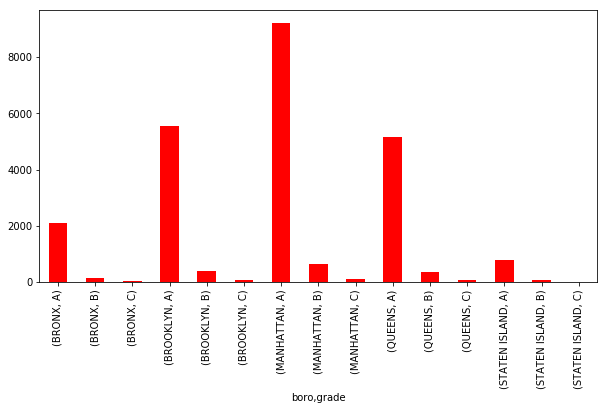

In [12]:
plt.figure(figsize=(10,5))
grade = clean.query('grade=="A"| grade=="B" | grade=="C" ').drop_duplicates('camis',keep='first')
grade['grade'].groupby(grade['boro']).value_counts().plot(kind = "bar",color=['r'])
plt.show()

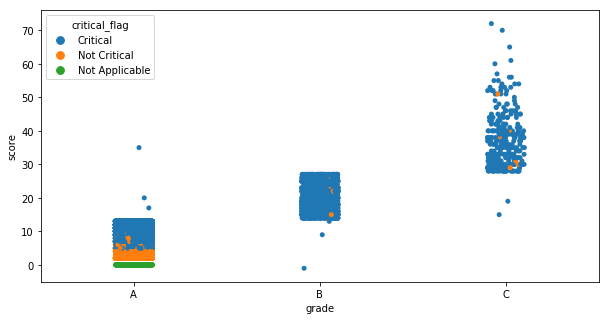

In [13]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.stripplot(x="grade", y = "score",hue = "critical_flag", data = grade, jitter=True)
plt.show()

**Step 4: Exploratory Analysis**

**Question 1:** Most hygienic restaurant for every cuisine (bakery, Asian, Mexican etc.)

In order to answer this question, we look at the latest scores of the restaurants i.e. restaurants graded in 2017. We want the scores to be more than or equal to 0

In [14]:
clean=clean[((clean.grade=='A') | (clean.grade=='B') | (clean.grade=='C'))]
clean.loc[clean[(clean.inspection_date>'12-31-2016') & (clean.score>=0)].groupby('cuisine_description')['score'].idxmin()][['dba','cuisine_description','score','grade']]

,dba,cuisine_description,score,grade
171881,AFGHAN KEBOB HOUSE,Afghan,4.0,A
335707,HONEY BEE'S KITCHEN,African,4.0,A
455,SONNY'S HEROS,American,0.0,A
361140,HOT DOG CONCESSION,Armenian,0.0,A
264011,ZHIQING ACTIVITY CENTER,Asian,0.0,A
356557,TWO HANDS TRIBECA,Australian,3.0,A
77750,EAT A BAGEL (On the Guy V. Molinari Ferry),Bagels/Pretzels,2.0,A
64641,MONA'S BAKERY & CAFE,Bakery,0.0,A
166574,CURRY HUT,Bangladeshi,4.0,A
227314,BED STUY,Barbecue,0.0,A


**Question 2: Most common health code violation**

In [15]:
clean.groupby(['violation_description','violation_code']).size().sort_values(ascending=False)[:10].to_frame(name='Count of violations')

# We can represent data in a cleaner way by using just violation codes
# clean.groupby(['violation_code']).size().sort_values(ascending=False)[:10]

,,Count of violations
violation_description,violation_code,
"Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.",10F,37443
Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.,08A,16854
"Food not protected from potential source of contamination during storage, preparation, transportation, display or service.",06C,14644
"Food contact surface not properly washed, rinsed and sanitized after each use and following any activity when contamination may have occurred.",06D,14576
Plumbing not properly installed or maintained; anti-siphonage or backflow prevention device not provided where required; equipment or floor not properly drained; sewage disposal system in disrepair or not functioning properly.,10B,13167
Cold food item held above 41Âº F (smoked fish and reduced oxygen packaged foods above 38 ÂºF) except during necessary preparation.,02G,12028
Evidence of mice or live mice present in facility's food and/or non-food areas.,04L,11265
Hot food item not held at or above 140Âº F.,02B,8218
"Filth flies or food/refuse/sewage-associated (FRSA) flies present in facilitys food and/or non-food areas. Filth flies include house flies, little house flies, blow flies, bottle flies and flesh flies. Food/refuse/sewage-associated flies include fruit flies, drain flies and Phorid flies.",04N,8051


**Step 5: Fetching Yelp Data**

In [16]:
import json
import requests
import sys
from time import sleep

CLIENT_ID = '***'
CLIENT_SECRET = '***'

CLIENT_ID2 = '***'
CLIENT_SECRET2= '***'

AUTH_URL = 'https://api.yelp.com/oauth2/token'
CREDS='<INSERT CLIENT CREDENTIAL TYPE>'
SEARCH_URL='https://api.yelp.com/v3/businesses/search'

def getToken():
    tokReq=requests.post(AUTH_URL,data={'grant_type':CREDS,'client_id':CLIENT_ID,'client_secret':CLIENT_SECRET})
    token=tokReq.json()['access_token']
    return token

def searchBusiness(df):
    token=getToken()
    print(token+" : Token received")
    yelp_format=clean.drop_duplicates('camis',keep='first')
    yelp_format['zipcode']=yelp_format['zipcode'].astype(int)
    lookups=yelp_format.loc[:,('camis','dba','zipcode')]
    resp=[]
    try:
        for i in lookups.itertuples():
            data=requests.get(SEARCH_URL,headers={"Authorization":"Bearer {0}".format(token)},params={"term":i.dba.replace(' ','+'),"location":i.zipcode,"limit":1})
            data=data.json()
            if(len(data['businesses'])>0):
                restID=data['businesses'][0]['id']
                restName=data['businesses'][0]['name']
                camisID=i.camis
                print(camisID,restName)
                restZip=data['businesses'][0]['location']['zip_code']
                isClosed=data['businesses'][0]['is_closed']
                reviewCount=data['businesses'][0]['review_count']
                ratingScore=data['businesses'][0]['rating']
                resp.append([camisID,restID,restName,restZip,isClosed,reviewCount,ratingScore])
            else:
                continue
    except Exception as e:
        print("Exception occurred: ",e)
    return resp
    
#We remove duplicate entries and store it in a new variable which will be later used to query data from YELP
yelp_data=searchBusiness(clean)
social=yelp_date.copy()
new_social=pd.DataFrame(data=social,columns=['camisID','restID','dba','zipcode','is_claimed','reviews','ratings'])
new_social.to_csv('yelp_data.csv')

**Step 6: Merging Datasets**<br>
Merging the cleaned data form DOHMH with the yelp data fetched by Left outerjoint based on camisId

In [17]:
social=pd.read_csv('yelp_data.csv')

merged=pd.merge(clean,social.loc[:,['camisID','is_claimed','reviews','ratings']],left_on='camis',right_on='camisID',how='left')
merged.to_csv("merged-data.csv")

In [18]:
dataset=pd.DataFrame({'camis':merged.camis,'boro':merged.boro,'cuisine_description':merged.cuisine_description,'score':merged.score,'grade':merged.grade,'is_claimed':merged.is_claimed,'reviews':merged.reviews,'rating':merged.ratings})
dataset=dataset[~dataset.rating.isnull()]
dataset=dataset.drop_duplicates('camis',keep='first')

In [19]:
length=len(dataset)
cuisines=dataset.groupby(['cuisine_description']).size()/(length/100)

for i in cuisines.index:
    if cuisines[i]<1:
        dataset['cuisine_description']=dataset['cuisine_description'].replace(i,'Other')

In [20]:
# We check the distribution of our target variable
dataset.groupby(['rating']).size()/(length/100)

rating
0.0     0.004300
1.0     1.199639
1.5     1.096444
2.0     3.039945
2.5     6.961345
3.0    14.481661
3.5    26.779034
4.0    31.354001
4.5    11.566410
5.0     3.517221
dtype: float64

**Step 7: Building Model**<br>

Splitting the dataset into testing and training data 

In [21]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
dataset['reviews']=preprocessing.scale(dataset['reviews'])
dataset['score']=preprocessing.scale(dataset['score'])
dataset=dataset.drop('camis',1)
sparseData=pd.get_dummies(dataset)
dataset_train, dataset_test, pred_train, pred_test = train_test_split(sparseData.drop('rating',1), sparseData.rating, test_size=0.2, random_state=3462)

In [22]:
# Example Confusion Matrix code from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
targetClasses=set(dataset.rating)

**Decision Tree**

The accuracy is: 34.03%
Confusion matrix, without normalization
[[  8   0   0   1   7   5   9   4  19]
 [  0   2   0   6  11  11  22   1   2]
 [  8   0   1   7  19  28  67   5  11]
 [  0   1   2  23  46  75 164   6   3]
 [  4   1   2  14  85 178 363   7  13]
 [  1   0   0  15  80 402 674  27  14]
 [  7   0   3  13  75 337 997  15  30]
 [  1   1   0   7  29 109 367  26   7]
 [ 16   0   0   5  20  18  67   9  39]]


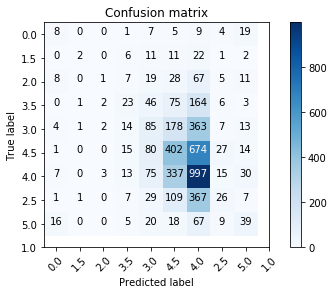

In [23]:
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

pred_train = ['{0}'.format(x) for x in pred_train]
pred_test = ['{0}'.format(x) for x in pred_test]

dtree=tree.DecisionTreeClassifier(random_state=3462,max_depth=10)
dtree.fit(X=dataset_train,y=pred_train)

dtree_output=dtree.predict(dataset_test)
print('The accuracy is: {0:.2f}%'.format(100*accuracy_score(y_true=pred_test,y_pred=dtree_output)))

confusionDT=confusion_matrix(y_true=pred_test,y_pred=dtree_output)
plt.figure()
plot_confusion_matrix(confusionDT, classes=targetClasses)


**Random Forest**

The accuracy is: 34.65%
Confusion matrix, without normalization
[[   1    0    0    0    6    5   28    0   13]
 [   0    0    1    2    3   20   29    0    0]
 [   0    0    1    6    6   50   75    2    6]
 [   0    0    1    9   14  120  176    0    0]
 [   0    0    0    4   27  218  411    1    6]
 [   0    0    1    7    1  402  801    1    0]
 [   1    0    0    6   15  297 1140    0   18]
 [   0    0    0    2    3  129  407    6    0]
 [   0    0    1    1    4   31  107    4   26]]


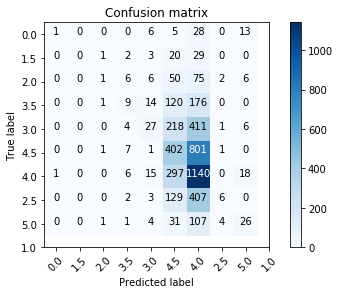

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_jobs=-1,random_state=3462,max_depth=10,n_estimators=100)
rf.fit(X=dataset_train,y=pred_train)
rf_output=rf.predict(dataset_test)
print('The accuracy is: {0:.2f}%'.format(100*accuracy_score(y_true=pred_test,y_pred=rf_output)))

confusionRF=confusion_matrix(y_true=pred_test,y_pred=rf_output)
plt.figure()
plot_confusion_matrix(confusionRF, classes=targetClasses)

**K-Nearest Neighbours**

The accuracy is: 32.82%
Confusion matrix, without normalization
[[  0   0   0   1   1  19  32   0   0]
 [  0   0   0   0   5  22  28   0   0]
 [  0   0   0   2  11  58  75   0   0]
 [  0   0   0   1  20 155 143   1   0]
 [  0   0   0   3  34 319 309   2   0]
 [  0   0   0   1  17 534 661   0   0]
 [  0   0   0   1  30 487 956   3   0]
 [  0   0   0   0   7 201 337   2   0]
 [  0   0   0   0   7  57 109   1   0]]


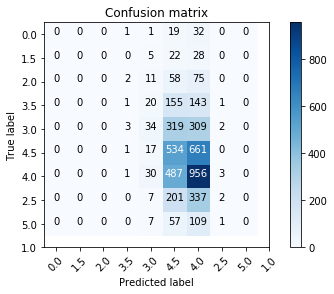

In [25]:
from sklearn.neighbors import KNeighborsClassifier

kNN=KNeighborsClassifier(n_neighbors=200,n_jobs=-1)
kNN.fit(X=dataset_train,y=pred_train)
kNN_output=kNN.predict(dataset_test)
print('The accuracy is: {0:.2f}%'.format(100*accuracy_score(y_true=pred_test,y_pred=kNN_output)))

confusionkNN=confusion_matrix(y_true=pred_test,y_pred=kNN_output)
plt.figure()
plot_confusion_matrix(confusionkNN, classes=targetClasses)

**Logistic Regresion**

The accuracy is: 33.58%
Confusion matrix, without normalization
[[   0    0    0    2    1   18   32    0    0]
 [   0    0    0    4    2   23   26    0    0]
 [   0    0    0    9    4   63   70    0    0]
 [   0    0    0    8   11  141  160    0    0]
 [   0    0    0    7   16  257  387    0    0]
 [   0    0    0    8    7  394  801    3    0]
 [   0    0    0    8   14  310 1140    5    0]
 [   0    0    0    1    8  118  416    4    0]
 [   0    0    0    2    1   63  103    5    0]]


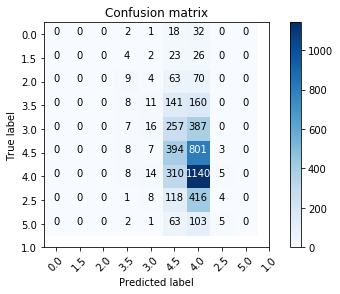

In [26]:
from sklearn import linear_model
logreg=linear_model.LogisticRegression(random_state=3462)
logreg.fit(dataset_train,pred_train)
lr_output=logreg.predict(dataset_test)
print('The accuracy is: {0:.2f}%'.format(100*accuracy_score(y_true=pred_test,y_pred=lr_output)))

confusionLR=confusion_matrix(y_true=pred_test,y_pred=lr_output)
plt.figure()
plot_confusion_matrix(confusionLR, classes=targetClasses)

**Support Vector Machine**

The accuracy is: 32.48%
Confusion matrix, without normalization
[[   0    0    0    0    0    8   45    0    0]
 [   0    0    0    0    0   16   39    0    0]
 [   0    0    0    0    0   41  105    0    0]
 [   0    0    0    0    0   77  243    0    0]
 [   0    0    0    0    0  129  538    0    0]
 [   0    0    0    0    0  205 1008    0    0]
 [   0    0    0    0    0  171 1306    0    0]
 [   0    0    0    0    0   44  503    0    0]
 [   0    0    0    0    0   30  144    0    0]]


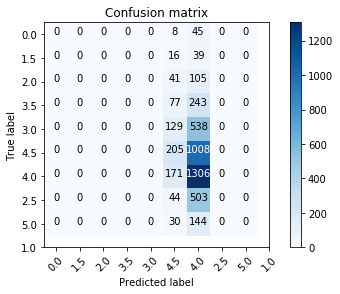

In [27]:
from sklearn.svm import SVC
clf = SVC(random_state=3462)
clf.fit(dataset_train,pred_train)
svm_output=clf.predict(dataset_test)
print('The accuracy is: {0:.2f}%'.format(100*accuracy_score(y_true=pred_test,y_pred=svm_output)))

confusionSVM=confusion_matrix(y_true=pred_test,y_pred=svm_output)
plt.figure()
plot_confusion_matrix(confusionSVM, classes=targetClasses)

Based on the accuracy of all the models, we conclude that Random Forest produces the best possible result. The "No Information Rate" i.e. the percentage of value held by the majority class is 31.35%. The jump in accuracy is merely 3.3% when we use Random Forest.<br/><br/>
By observing the Confusion Matrix and the graph, we can conclude that Random Forest is best at identifying true psitives and true negatives. SVM appears to be good with classifying the majority class but fails to consider minority classes.
<br/><br/>
What this indicates about our project is that customers seldom care about the sanitary grade of the restaurant before posting their reviews and ratings on Yelp. Although hygiene should be a priority for customers, it does not appear that customers in New York city favour one restaurant over the other solely on the basis of their sanitary grade.